For SNOW data 
- Save the raw data to parquet file
- Join w veg data to reduce # of grids
  - Exclude water, agricultural lands, and urban areas based on the vegetation type data.

In [38]:
# Force garbage collection
import gc
gc.collect()

3139

In [39]:
# del all variables
import sys
for name in dir():
    if not name.startswith('_'):
        del globals()[name]

In [40]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import pyproj
from tqdm import tqdm
import numpy as np
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime

In [41]:
# check python version and all packages version
def check_python_version():
    import sys
    print("Python version")
    print (sys.version)
    print("Pandas version")
    print(pd.__version__)
    print("Geopandas version")
    print(gpd.__version__)
    print("Xarray version")
    print(xr.__version__)
    print("Pyproj version")
    print(pyproj.__version__)

check_python_version()

Python version
3.11.9 | packaged by Anaconda, Inc. | (main, Apr 19 2024, 16:40:41) [MSC v.1916 64 bit (AMD64)]
Pandas version
2.2.2
Geopandas version
0.14.2
Xarray version
2023.6.0
Pyproj version
3.6.1


In [42]:
files = os.listdir('../../Extended_Data/Snow/')
files

['SWE.WY.1994.2020.CA.interpolated.nc', 'SWE.WY.1994.2020.CA.nc']

In [43]:
data_dir = '../../Extended_Data/Snow/'
file = 'SWE.WY.1994.2020.CA.interpolated.nc'

In [44]:
ds = xr.open_dataset(os.path.join(data_dir, file))
print(f"File: {file}")
print(f"Dimensions: {ds.dims}")
print(f"Day range: {ds.coords['time'].min().values} to {ds.coords['time'].max().values}")
print(f"Coordinates: {ds.coords}")
print(f"Data variables: {ds.data_vars}")

File: SWE.WY.1994.2020.CA.interpolated.nc
Dimensions: Frozen({'time': 9862, 'lat': 238, 'lon': 258})
Day range: 1993-10-01T00:00:00.000000000 to 2020-09-30T00:00:00.000000000
Coordinates: Coordinates:
  * time     (time) datetime64[ns] 1993-10-01 1993-10-02 ... 2020-09-30
  * lat      (lat) float64 42.19 42.15 42.11 42.07 ... 32.44 32.4 32.36 32.32
  * lon      (lon) float64 -124.7 -124.6 -124.6 -124.6 ... -114.1 -114.0 -114.0
Data variables: Data variables:
    SWE      (time, lat, lon) float32 ...
    DEPTH    (time, lat, lon) float32 ...


In [45]:
# drop DEPTH from data variables
ds = ds.drop_vars('DEPTH')

In [46]:
ds

<xarray.Dataset>
Dimensions:  (time: 9862, lat: 238, lon: 258)
Coordinates:
  * time     (time) datetime64[ns] 1993-10-01 1993-10-02 ... 2020-09-30
  * lat      (lat) float64 42.19 42.15 42.11 42.07 ... 32.44 32.4 32.36 32.32
  * lon      (lon) float64 -124.7 -124.6 -124.6 -124.6 ... -114.1 -114.0 -114.0
Data variables:
    SWE      (time, lat, lon) float32 ...
Attributes: (12/15)
    processing_date:       2025-06-11T15:04:16.059802
    processing_note:       Masked to California and cropped
    original_shape:        (365, 621, 1405)
    processed_shape:       (365, 238, 258)
    title:                 California SWE Data 1994-2000
    description:           Merged and masked SWE data for California
    ...                    ...
    source_files:          CA_4km_SWE_Depth_WY1994_v01.nc, CA_4km_SWE_Depth_W...
    coordinate_alignment:  matched to target grid
    target_grid_source:    ca_masked_fm100_1994.nc
    alignment_method:      direct_assignment
    aligned_on:            2025-06-13T23:22:07.254632
    lat_order:             descending (matches target)

In [47]:
snow_pd = ds.to_dataframe().reset_index()

In [48]:
snow_pd.head()

,time,lat,lon,SWE
0,1993-10-01,42.191667,-124.683333,NaN
1,1993-10-01,42.191667,-124.641667,NaN
2,1993-10-01,42.191667,-124.600000,NaN
3,1993-10-01,42.191667,-124.558333,NaN
4,1993-10-01,42.191667,-124.516667,NaN


In [49]:
reference_weather_data = pd.read_parquet('../../Clean_Data/Weather_Data/Extended_Weather_Data/wind_speed.parquet')
reference_weather_data = reference_weather_data[reference_weather_data['day']=='1998-01-01']
reference_weather_data = reference_weather_data[['lon', 'lat']].drop_duplicates()
reference_weather_data.shape

(61404, 2)

In [50]:
snow_pd_lon_lat = snow_pd[['lon', 'lat']].drop_duplicates()
snow_pd_lon_lat.shape

(61404, 2)

In [51]:
reference_weather_data.head()

,lon,lat
1461,-124.683333,42.191667
4018,-124.683333,42.150000
6575,-124.683333,42.108333
9132,-124.683333,42.066667
11689,-124.683333,42.025000


In [52]:
snow_pd_lon_lat.head()

,lon,lat
0,-124.683333,42.191667
1,-124.641667,42.191667
2,-124.600000,42.191667
3,-124.558333,42.191667
4,-124.516667,42.191667


In [53]:
test_merge = snow_pd_lon_lat.merge(reference_weather_data, on=['lon', 'lat'], how='inner')
# if test_merge.shape is same as reference_weather_data, then the merge is successful
if test_merge.shape == snow_pd_lon_lat.shape:
    print("Merge successful")
else:
    # print test_merge shape and reference_weather_data shape
    print(f"Merge failed: {test_merge.shape} != {reference_weather_data.shape}")

Merge successful


## Missing Rate

In [58]:
# add year column to snow_pd
snow_pd['year'] = snow_pd['time'].dt.year

In [59]:
# check missing rate
weather_variable = 'SWE'
# group by water year
missing_rate_by_year = snow_pd.groupby('year')[weather_variable].apply(lambda x: x.isnull().mean())

In [60]:
missing_rate_by_year

year
1993    0.613934
1994    0.613934
1995    0.613934
1996    0.613934
1997    0.613934
1998    0.613934
1999    0.613934
2000    0.613934
2001    0.613934
2002    0.613934
2003    0.613934
2004    0.613934
2005    0.613934
2006    0.613934
2007    0.613934
2008    0.613934
2009    0.613934
2010    0.613934
2011    0.613934
2012    0.613934
2013    0.613934
2014    0.613934
2015    0.613934
2016    0.613934
2017    0.613934
2018    0.613934
2019    0.613934
2020    0.613934
Name: SWE, dtype: float64

In [ ]:
path_to_save = '../../Clean_Data/Weather_Data/Combined_Weather_Data/'
# Ensure the output directory exists
if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)

output_file = f'{path_to_save}/{file.split(".")[0]}.parquet'
snow_pd.to_parquet(output_file)

print(f"Saved {file} as {output_file}")

# clean up
del ds, snow_pd, reference_weather_data, snow_pd_lon_lat, test_merge, missing_rate_by_year

Saved SWE.WY.1994.2020.CA.interpolated.nc as ../../Clean_Data/Weather_Data/Combined_Weather_Data//SWE.parquet


NameError: name 'gc' is not defined

In [80]:
import gc
gc.collect()

21

## Merge w Veg Data

In [79]:
# clean up memory
gc.collect()
# delete all dataframes
for var in list(globals().keys()):
    if isinstance(globals()[var], pd.DataFrame):
        del globals()[var]

In [13]:
import os
from datetime import datetime

In [2]:
# the data is generated from 02 Veg Data Extract.ipynb
import pandas as pd
veg_data = pd.read_parquet('../../Clean_Data/lon_lat_pair_weather_match_veg_v2.parquet')

In [3]:
veg_data.shape

(17703, 7)

In [65]:
veg_data.head()

,lon,lat,type,distance,veg_type_details,fire_attribute,veg
0,-124.391667,40.441667,7.0,1.826642,Native Coastal Sage Scrub - fire,fire,Native Coastal Sage Scrub
1,-124.391667,40.400000,25.0,1.827314,Native Oak Woodland - fire,fire,Native Oak Woodland
2,-124.350000,40.566667,1.0,1.824622,Agriculture - low,low,Agriculture
3,-124.350000,40.525000,8.0,1.825296,Native Coastal Sage Scrub - mesic,mesic,Native Coastal Sage Scrub
4,-124.350000,40.483333,25.0,1.825969,Native Oak Woodland - fire,fire,Native Oak Woodland


In [66]:
veg_data[['lon', 'lat']].duplicated().sum()

0

In [4]:
veg_data_filter = veg_data[~veg_data['veg'].str.contains('Water|Urban|Agriculture')]

In [5]:
veg_data_filter.shape

(14383, 7)

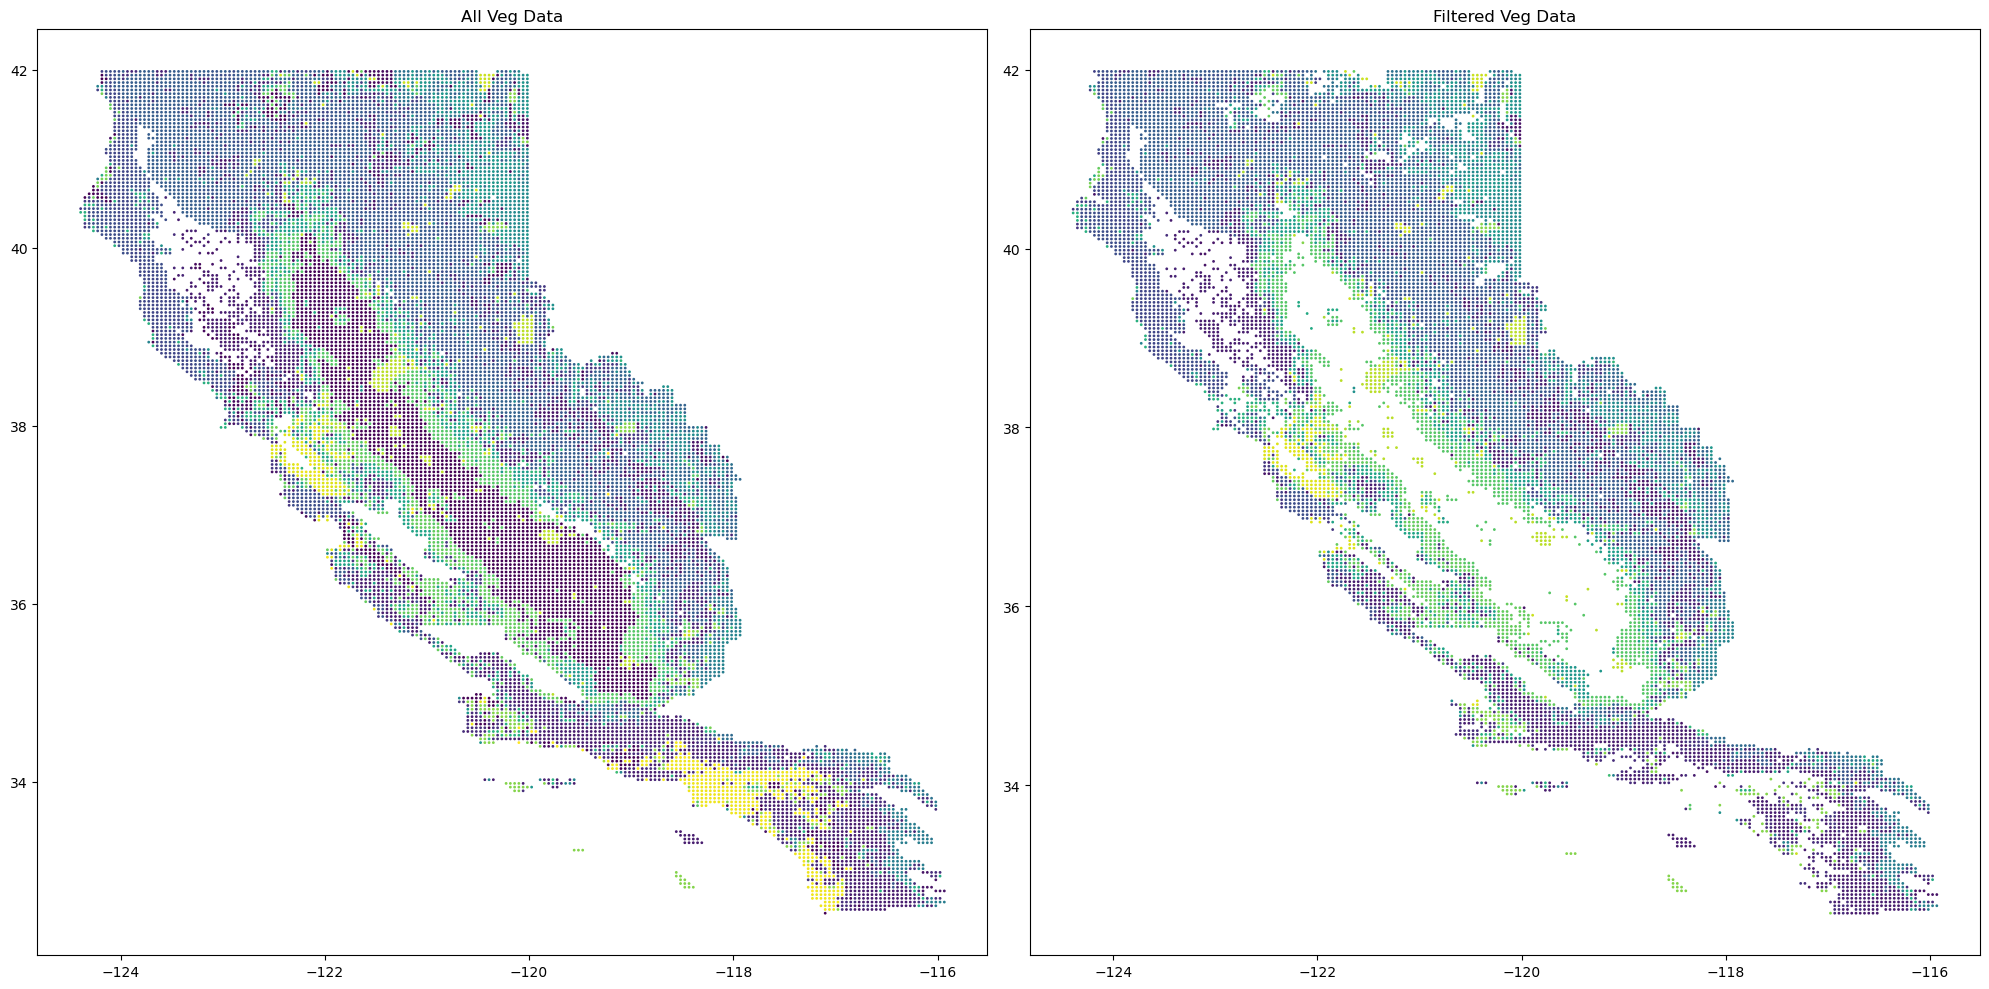

In [69]:
vmin = min(veg_data['type'].min(), veg_data_filter['type'].min())
vmax = max(veg_data['type'].max(), veg_data_filter['type'].max())

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

sc1 = axes[0].scatter(
    veg_data['lon'], veg_data['lat'],
    c=veg_data['type'], cmap='viridis', s=1, vmin=vmin, vmax=vmax
)
axes[0].set_title('All Veg Data')

sc2 = axes[1].scatter(
    veg_data_filter['lon'], veg_data_filter['lat'],
    c=veg_data_filter['type'], cmap='viridis', s=1, vmin=vmin, vmax=vmax
)
axes[1].set_title('Filtered Veg Data')

# Add a shared colorbar
#cbar = fig.colorbar(sc2, ax=axes, orientation='vertical', fraction=0.03, pad=0.04)
#cbar.set_label('Type')

plt.tight_layout()
plt.show()
plt.close()

In [6]:
file = 'SWE.parquet'

In [14]:
path_to_read = '../../Clean_Data/Weather_Data/Combined_Weather_Data/'
path_to_save = '../../Clean_Data/Weather_Data/Combined_Weather_Data_w_Veg_Filter/'
# Ensure the output directory exists
if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)

print("Task: Data cleaning on extended SNOW data with vegetation filter")
print(f"Processing started on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


dat = pd.read_parquet(f'{path_to_read}/{file}')
print(f"Processing file: {file}, shape: {dat.shape}")
dat_filtered = pd.merge(dat, veg_data_filter[['lon', 'lat']], on=['lon', 'lat'], how='inner')
print(f"Filtered DataFrame shape: {dat_filtered.shape}")
del dat  # Free up memory
dat_filtered.to_parquet(f'{path_to_save}/{file}')

Task: Data cleaning on extended SNOW data with vegetation filter
Processing started on: 2025-06-14 11:25:16
Processing file: SWE.parquet, shape: (605566248, 5)
Filtered DataFrame shape: (141845146, 5)


In [15]:
# check missing rate again
missing_rate_by_year = dat_filtered.groupby('year')['SWE'].apply(lambda x: x.isnull().mean())
missing_rate_by_year

year
1993    0.03963
1994    0.03963
1995    0.03963
1996    0.03963
1997    0.03963
1998    0.03963
1999    0.03963
2000    0.03963
2001    0.03963
2002    0.03963
2003    0.03963
2004    0.03963
2005    0.03963
2006    0.03963
2007    0.03963
2008    0.03963
2009    0.03963
2010    0.03963
2011    0.03963
2012    0.03963
2013    0.03963
2014    0.03963
2015    0.03963
2016    0.03963
2017    0.03963
2018    0.03963
2019    0.03963
2020    0.03963
Name: SWE, dtype: float64